In [1]:
# Based on Google's Udacity Deep Learning course, Assignments 1-4

%reload_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
import warnings
assert os.path.basename(os.getcwd()) == 'notebooks', os.path.basename(os.getcwd())
code_dir = os.path.join(os.getcwd(), os.pardir, 'code')
if code_dir not in sys.path:
    sys.path.append(code_dir)
    os.environ['PYTHONPATH'] = os.environ.get('PYTHONPATH', '') + os.pathsep + code_dir
model_dir = os.path.join(os.getcwd(), os.pardir, 'models')
data_dir = os.path.join(os.getcwd(), os.pardir, 'data')
   
import keras
%aimport keras_util

Using TensorFlow backend.


In [2]:
from keras.utils import get_file
import string

def fullpath_listdir(dirname):
    return [os.path.join(dirname, fname) for fname in os.listdir(dirname)]    

def get_notmnist_tgz(base, expected_count, expected_classes):
    notmnist_origin = 'https://commondatastorage.googleapis.com/books1000/'
    subdir = 'notmnist'
    target = os.path.join(data_dir, subdir, base)
    if os.path.isdir(target):
        classdirs = fullpath_listdir(target)
        num_class_files = [len(os.listdir(classdir)) for classdir in classdirs]
        all_examples_present = all(num_files >= expected_count for num_files in num_class_files)
        all_classes_present = all(i in os.listdir(target) for i in expected_classes)
        if all_classes_present and all_examples_present:
            print(base, 'already extracted')
            return target
    ext = '.tar.gz'
    get_file(base + ext, notmnist_origin + base + ext, cache_dir=data_dir, cache_subdir=subdir, extract=True)
    return target

classes = string.ascii_uppercase[:10]
train_dir = get_notmnist_tgz('notMNIST_large', 50000, classes)
test_dir = get_notmnist_tgz('notMNIST_small', 1800, classes)

notMNIST_large already extracted
notMNIST_small already extracted


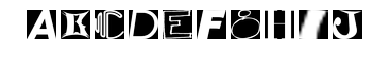

images are 28x28


In [3]:
import numpy as np
classdirs = fullpath_listdir(train_dir)
classdirs.sort()
np.random.seed(1234)
selected_images = [np.random.choice(fullpath_listdir(classdir)) for classdir in classdirs]

from matplotlib.image import imread

# https://stackoverflow.com/questions/36006136/
fig = plt.figure()
for i, f in enumerate(selected_images, start=1):
    ax = fig.add_subplot(1, len(selected_images), i)
    plt.imshow(imread(f), cmap='Greys_r')
    plt.axis('off')

plt.show()

imheight, imwidth = imread(selected_images[0]).shape
print('images are {}x{}'.format(imwidth, imheight))

### Raw Data Ingestion

Load all the pictures as greyscale matrices, and deduplicate exact matches

In [4]:
from keras.preprocessing.image import img_to_array, load_img
import multiprocessing
import contextlib
from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Memory

onehot = MultiLabelBinarizer().fit(classes)

def img_from_file(fname):
    im = load_img(fname, grayscale=True, target_size=(imheight, imwidth))
    return img_to_array(im, data_format='channels_last')

train_classdirs = fullpath_listdir(train_dir)

def no_rows(*shape):
    shape_tup = (0, ) + tuple(shape)
    return np.empty(shape=shape_tup, dtype=np.float32)


def labelled_img(fname):
    try:
        label = os.path.basename(os.path.dirname(fname))
        x = img_from_file(fname).reshape(1, imheight, imwidth, 1)
        y = onehot.transform(label).astype(np.float32)
        return x, y
    except IOError as e:
        print(e)
    return no_rows(28, 28, 1), no_rows(10)

memory = Memory(cachedir=os.path.join(train_dir, os.path.pardir), verbose=2)

@memory.cache
def load_raw(directory):
    all_fnames = [
        f for clsdir in fullpath_listdir(directory)
        if os.path.isdir(clsdir) for f in fullpath_listdir(clsdir)
    ]
    with contextlib.closing(
            multiprocessing.Pool(multiprocessing.cpu_count())) as pool:
        xy = pool.map(labelled_img, all_fnames, chunksize=100)
        return tuple(np.vstack(ls) for ls in zip(*xy))

In [5]:
import contexttimer
from tabulate import tabulate

with contexttimer.Timer() as train_time:
    trainx, trainy = load_raw(train_dir)
    
with contexttimer.Timer() as test_time:
    testx, testy = load_raw(test_dir)

print(tabulate(
    [['train', trainx.shape, trainy.shape, train_time.elapsed],
     ['test', testx.shape, testy.shape, test_time.elapsed]],
    ['data set', 'x {}'.format(trainx.dtype), 'y {}'.format(trainy.dtype), 'load time'],
    tablefmt='grid'))

[Memory]    0.0s, 0.0min: Loading load_raw...
[Memory]    0.8s, 0.0min: Loading load_raw...
+------------+---------------------+--------------+-------------+
| data set   | x float32           | y float32    |   load time |
+============+=====================+==============+=============+
| train      | (529114, 28, 28, 1) | (529114, 10) |   0.814073  |
+------------+---------------------+--------------+-------------+
| test       | (18724, 28, 28, 1)  | (18724, 10)  |   0.0313581 |
+------------+---------------------+--------------+-------------+


In [6]:
# Deduplicate exactly-equal images
@memory.cache
def unique_rows(matrix_name):
    nparr = eval(matrix_name)
    assert nparr.ndim > 1
    matrix = nparr.reshape(len(nparr), -1)
    _, ind = np.unique(matrix, axis=0, return_index=True)
    return ind

unique_ind = unique_rows('trainx')
print('dedup reduced training size from {} to {}'.format(len(trainx), len(unique_ind)))
trainx, trainy = trainx[unique_ind], trainy[unique_ind]

[Memory]    0.9s, 0.0min: Loading unique_rows...
dedup reduced training size from 529114 to 461946


In [7]:
from sklearn.model_selection import train_test_split

train_and_validx, train_and_validy = trainx, trainy
trainx, validx, trainy, validy = train_test_split(trainx, trainy, test_size=0.3, random_state=5678)

### LR baseline

In [8]:
import keras.backend as K
from keras.layers import *
from keras.models import Sequential, Model

In [9]:
# Drop down to tf to use scipy optimization wrapper
# Very slow to train unless using tnc

from keras.objectives import categorical_crossentropy
import tensorflow as tf

def get_logistic(use_cached=True):
    K.clear_session()
    keras_util.seedall()

    inputs = K.constant(train_and_validx)
    logistic = Sequential(
        [Flatten(input_shape=train_and_validx.shape[1:]),
         Dense(10, activation='softmax', name='dense')])
    if os.path.isfile('weights') and use_cached:
        print('loading cached weights')
        logistic.load_weights('weights')
    else:
        outputs = logistic(inputs)
        labels = K.constant(train_and_validy)

        loss = K.mean(categorical_crossentropy(labels, outputs))
        acc = K.mean(
                K.equal(K.argmax(labels, axis=1),
                        K.argmax(outputs, axis=1)))
        opt = tf.contrib.opt.ScipyOptimizerInterface(
            loss, method='tnc', options={'maxiter': 10000, 'disp': True})
        
        tb = keras.callbacks.TensorBoard(log_dir='logs')
        tb.set_model(logistic)

        def make_loss_callback(step):
            epoch = 0
            def loss_callback(loss, acc):
                nonlocal epoch, tb
                logs = {'loss': loss, 'acc': acc}
                tb.on_epoch_end(epoch, logs)
                epoch += 1
                if epoch % step == 0 or epoch == 1:
                    print('step {:4d} loss {:7.4f} acc {:6.4f}'.format(epoch, loss, acc))
            return loss_callback

        K.get_session().run(tf.global_variables_initializer())
        opt.minimize(
            K.get_session(), fetches=[loss, acc], loss_callback=make_loss_callback(500))
        tb.on_train_end(None)

        logistic.save('weights')
        
    logistic.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return logistic

with keras_util.rectime('logistic training took {:4.0f} sec'):
    with keras_util.cd(os.path.join(model_dir, 'notmnist', 'logistic')):
        logistic = get_logistic()
keras_util.evaluate(logistic, testx, testy, batch_size=len(testx))

step    1 loss 14.5933 acc 0.0880
step  500 loss  3.1910 acc 0.8014
step 1000 loss  2.9232 acc 0.8180
step 1500 loss  2.8299 acc 0.8238
step 2000 loss  2.7948 acc 0.8260
step 2500 loss  2.7853 acc 0.8267
step 3000 loss  2.7817 acc 0.8270
step 3500 loss  2.7796 acc 0.8272
step 4000 loss  2.7773 acc 0.8274
step 4500 loss  2.7754 acc 0.8276
step 5000 loss  2.7731 acc 0.8277
step 5500 loss  2.7851 acc 0.8267
step 6000 loss  2.7700 acc 0.8279
step 6500 loss  2.7683 acc 0.8280
step 7000 loss  2.7666 acc 0.8282
step 7500 loss  2.7655 acc 0.8283
step 8000 loss  2.7650 acc 0.8284
step 8500 loss  2.7648 acc 0.8284
step 9000 loss  2.7647 acc 0.8285
step 9500 loss  5.1118 acc 0.6816
step 10000 loss  2.7645 acc 0.8284
INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 2.764348
  Number of iterations: 300
  Number of functions evaluations: 10000
logistic training took  677 sec
18724/18724 [==============================] -

{'acc': 0.89756464958190918, 'loss': 1.6411033868789673}

### Resnet-like architecture

In [10]:
from keras.applications.resnet50 import conv_block, identity_block

def greyscale_resnet(input_shape, nclasses):
    
    assert len(input_shape) == 3, input_shape
    assert input_shape[-1] == 1, input_shape
    
    img = Input(shape=input_shape, dtype=K.floatx(), name='greyscale_input_img')

    x = Conv2D(64, (7, 7), padding='same', name='conv1')(img)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [64, 64, 128], stage=2, block='conv')
    for i in range(5):
        x = identity_block(x, 3, [64, 64, 128], stage=2, block='id{}'.format(i))
        
    x = conv_block(x, 3, [128, 128, 256], stage=3, block='conv')
    for i in range(5):
        x = identity_block(x, 3, [128, 128, 256], stage=3, block='id{}'.format(i))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(nclasses, activation='softmax', name='fc')(x)
    
    return Model(img, x, name='resnet')

In [11]:
import io

def fresh_resnet():
    K.clear_session()
    keras_util.seedall()

    with keras_util.rectime('generating  {:4.0f} sec'):
        greyres = greyscale_resnet(trainx.shape[1:], len(classes))

    return greyres

f = io.StringIO()
with contextlib.redirect_stdout(f):
    fresh_resnet().summary()
print('\n'.join(f.getvalue().split('\n')[-6:]))

Total params: 1,687,306
Trainable params: 1,677,194
Non-trainable params: 10,112
____________________________________________________________________________________________________



In [12]:
import multigpu

def serial_resnet():
    greyres = fresh_resnet()

    with keras_util.rectime('compiling   {:4.0f} sec'):
        greyres.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
        
    return greyres

def parallel_resnet():
    greyres = fresh_resnet()

    with keras_util.rectime('parallelize {:4.0f} sec'):
        greyres = multigpu.make_parallel(greyres)

    with keras_util.rectime('compiling   {:4.0f} sec'):
        greyres.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
    return greyres

NCCL support available


In [13]:
from keras.preprocessing.image import ImageDataGenerator

def minibench(model, name, batch_size):
    steps = 16
    gen = ImageDataGenerator().flow(trainx, trainy, batch_size=batch_size, seed=1234)
    with keras_util.rectime('warmup      {:4.0f} sec'):
        model.fit_generator(gen, steps_per_epoch=steps, epochs=1, verbose=0)
    with contexttimer.Timer() as t:
        model.fit_generator(gen, steps_per_epoch=steps, epochs=1)
    expected = int(t.elapsed * len(trainx) / batch_size / steps)
    print('{} expected epoch runtime {} sec'.format(name, expected))

# Only start to see improvement in parallel net around large batches
batch_size = 2048

par_res = parallel_resnet()
minibench(par_res, 'multi-gpu net', batch_size)

ser_res = serial_resnet()
minibench(ser_res, 'serial net', batch_size)

generating     2 sec
parallelize    3 sec
compiling      1 sec
warmup        29 sec
Epoch 1/1
16/16 [==============================] - 8s - loss: 1.3364 - acc: 0.7170     
multi-gpu net expected epoch runtime 86 sec
generating     2 sec
compiling      0 sec
warmup        28 sec
Epoch 1/1
16/16 [==============================] - 16s - loss: 1.2596 - acc: 0.7083    
serial net expected epoch runtime 158 sec


In [14]:
std_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)
perturb_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    fill_mode='constant'
)

def fit_generators(x, *gens):
    with warnings.catch_warnings():
        # As of Aug 2017, keras fires a user warning when augmenting greyscale
        # images, even though its API supports it. The spurious warning has
        # been fixed but the fix isn't released yet.
        warnings.filterwarnings("ignore", message='Expected input to be images')
        for gen in gens:
            gen.fit(x)
fit_generators(trainx, std_gen, perturb_gen)

net = parallel_resnet()

train_batch_size = 1024
valid_batch_size = 5096
train_gen = perturb_gen.flow(trainx, trainy, batch_size=train_batch_size, seed=5678)
valid_gen = std_gen.flow(validx, validy, batch_size=valid_batch_size, shuffle=False)

with keras_util.rectime('training took {:4.0f} sec'):
    with keras_util.cd(os.path.join(model_dir, 'notmnist', 'residual')):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        lr = keras.callbacks.ReduceLROnPlateau(patience=5)
        checkpoint = keras.callbacks.ModelCheckpoint(
            'weights', monitor='val_loss', save_best_only=True)
        tb = keras.callbacks.TensorBoard(log_dir='logs')
        callbacks = [early_stopping, lr, checkpoint, tb]
        net.fit_generator(
            train_gen,
            verbose=1,
            steps_per_epoch=(len(trainx) // train_batch_size),
            epochs=500,
            callbacks=callbacks,
            validation_data=valid_gen,
            validation_steps=(len(validx) // valid_batch_size))
        net.load_weights('weights')

generating     2 sec
parallelize    2 sec
compiling      1 sec
Epoch 1/500
315/315 [==============================] - 115s - loss: 1.0668 - acc: 0.7533 - val_loss: 0.4443 - val_acc: 0.8712
Epoch 2/500
315/315 [==============================] - 107s - loss: 0.4721 - acc: 0.8565 - val_loss: 0.3613 - val_acc: 0.8916
Epoch 3/500
315/315 [==============================] - 107s - loss: 0.4078 - acc: 0.8749 - val_loss: 0.3255 - val_acc: 0.9010
Epoch 4/500
315/315 [==============================] - 107s - loss: 0.3673 - acc: 0.8868 - val_loss: 0.3075 - val_acc: 0.9053
Epoch 5/500
315/315 [==============================] - 107s - loss: 0.3411 - acc: 0.8936 - val_loss: 0.2965 - val_acc: 0.9076
Epoch 6/500
315/315 [==============================] - 107s - loss: 0.3239 - acc: 0.8987 - val_loss: 0.2847 - val_acc: 0.9124
Epoch 7/500
315/315 [==============================] - 107s - loss: 0.3098 - acc: 0.9033 - val_loss: 0.2660 - val_acc: 0.9180
Epoch 8/500
315/315 [==============================] - 

In [30]:
def to_std(x, y):
    gen = std_gen.flow(x, y, batch_size=len(x), shuffle=False)
    return next(gen)

# post-training (training on train + validation until loss on the
# aggregate set is equal to post-training loss on train) doesn't help much:
# only improves test acc by ~0.0001
print(keras_util.evaluate(net, *to_std(testx, testy), 
                          batch_size=valid_batch_size))

18724/18724 [==============================] - 2s     
{'acc': 0.98328366001506462, 'loss': 0.059234185202003062}


### FAISS image similarity

The below isn't really relevant to the classification problem, just messing around with FAISS.

In [ ]:
train_matrix = trainx.reshape(trainx.shape[0], -1)
num_vecs, vec_dim = train_matrix.shape

In [ ]:
import faiss

ngpu = keras_util.ngpu()
# faiss uses swig, which fails unless we hold all these objects
# in lists explicitly
resources = [faiss.StandardGpuResources() for i in range(ngpu)]

index = faiss.index_factory(vec_dim, 'IVF{},Flat'.format(int(np.sqrt(num_vecs) * 10)))
index.nprobe = 10
opts = faiss.GpuMultipleClonerOptions()
index = faiss.index_cpu_to_gpu_multiple_py(resources, index, opts)

In [ ]:
with contexttimer.Timer() as t:
    index.train(train_matrix)
    index.add(train_matrix)
print('Trained image similarity index in {:.2f} sec'.format(t.elapsed))

In [ ]:
k = 10
with contexttimer.Timer() as t:
    distances, indices = index.search(train_matrix, k)
print('Found top-{} similarity matches for all images in {:.2f} sec'.format(k, t.elapsed))

In [ ]:
# Free GPU memory
del index, resources, opts

In [ ]:
fig = plt.figure()
np.random.seed(1234)
nsamples = 5
selected_images = np.random.choice(np.arange(len(indices)), nsamples)
image_indices = np.concatenate([indices[i] for i in selected_images])
for i, image_index in enumerate(image_indices, start=1):
    ax = fig.add_subplot(nsamples, k, i)
    plt.imshow(trainx[image_index], cmap='Greys_r')
    plt.axis('off')

plt.show()

The above shows that L2 metric on the raw image data might not be enough since clearly different fonts for the same letter are viewed as neighbors, even though we'd like to match only with the same font that's been repeated between two images (but isn't an exact duplicate, since those were already filtered out).